# Prepare your own data
While the SDV offers many publicly available demo datasets, you may want to use one of your own, private datasets for synthetic data creation.

In this notebook, we'll cover the basics of how you can prepare your data for the SDV. This includes loading your data and writing a metadata description of the tables.

_Last Edit: Oct 2, 2024_

# 0. Installation

Install the SDV library.

In [144]:
# %pip install sdv

# Imports

In [145]:
import os, datetime
import pandas as pd
from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CopulaGANSynthesizer
from rdt.transformers.categorical import OrderedUniformEncoder
from rdt.transformers.datetime import OptimizedTimestampEncoder
from rdt.transformers.numerical import GaussianNormalizer
from sdmetrics.visualization import get_column_plot
from sdv.sampling import Condition
import numpy as np



# 1. Loading the data

In [146]:
# File path to the Excel file
file_path = 'Dataset_2.0_Akkodis.xlsx'

# Import the dataset into a pandas DataFrame
data = pd.read_excel(file_path)

data.columns = data.columns.str.strip()
data['Overall'] = data['Overall'].str.lstrip('~ ') # Makes entries consistent
data[['City', 'Province', 'Region']] = data['Residence'].str.extract(r'^(.*?) » (.*?) ~ (.*)$')
# data['Year of insertion'] = data['Year of insertion'].str.strip('[]')
# data['Year of Recruitment'] = data['Year of Recruitment'].str.strip('[]')
data['Year of insertion'] = pd.to_numeric(data['Year of insertion'].str.strip('[]'), errors='coerce').astype('Int64')
data['Year of Recruitment'] = pd.to_numeric(data['Year of Recruitment'].str.strip('[]'), errors='coerce').astype('Int64')
data = data.drop(columns=['Residence'])
undesired_values = ['????', '-', '.']
data = data[~data['Last Role'].isin(undesired_values)]

print(data.head)


<bound method NDFrame.head of           ID Candidate State      Age Range   Sex Protected category  \
0      71470           Hired  31 - 35 years  Male                NaN   
1      71470           Hired  31 - 35 years  Male                NaN   
2      71470           Hired  31 - 35 years  Male                NaN   
3      71470           Hired  31 - 35 years  Male                NaN   
4      71470           Hired  31 - 35 years  Male                NaN   
...      ...             ...            ...   ...                ...   
21372  79993           Hired  26 - 30 years  Male                NaN   
21373  79993           Hired  26 - 30 years  Male                NaN   
21374  79993           Hired  26 - 30 years  Male                NaN   
21375  79993           Hired  26 - 30 years  Male                NaN   
21376  79993           Hired  26 - 30 years  Male                NaN   

                                                     TAG  \
0      AUTOSAR, CAN, C, C++, MATLAB/SIMULINK,

In [147]:
print(data['Year of Recruitment'].head)

<bound method NDFrame.head of 0        2021
1        2021
2        2021
3        2021
4        2021
         ... 
21372    2023
21373    2023
21374    2023
21375    2023
21376    2023
Name: Year of Recruitment, Length: 21235, dtype: Int64>


## Data Cleaning

Some IDs are inconsistent, meaning a new entry was made with another contextual variable (Age Range, Sex or Region for instance). Although it could mean that the same candidate has applied again where the contextual variable has changed, it makes sequential analysis a lot harder. Therefore, we will remove the inconsistent rows.

In [148]:
# Columns to exclude (because these will not be contextual inputs)
exclude_columns = [
'ID',
'event_type__val',
'event_feedback',
'linked_search__key',
'Overall',
'Technical Skills',	
'Standing/Position',
'Comunication',	
'Maturity',	
'Dynamism',	
'Mobility',	
'English'
]

# Get columns as a list, excluding specific ones
filtered_columns = [col for col in data.columns if col not in exclude_columns]

# List of columns to check for inconsistencies
columns_to_check = filtered_columns

# Check for duplicate IDs where other columns differ
# Group by 'ID' and check for unique values across the specified columns
id_inconsistencies = data.groupby('ID')[columns_to_check].nunique()

# Filter for IDs with inconsistencies (more than one unique value in any critical column)
inconsistent_ids = id_inconsistencies[id_inconsistencies.gt(1).any(axis=1)]

# Sort the dataset by 'ID' and reset the index to ensure sequential appearance
data_sorted = data.sort_values(by=['ID']).reset_index()

# Identify rows belonging to inconsistent IDs
inconsistent_rows = data_sorted['ID'].isin(inconsistent_ids.index)

# Create a mask to keep only the first group of rows for each inconsistent ID
data = data_sorted[~inconsistent_rows | (data_sorted['ID'] != data_sorted['ID'].shift())]

# Drop the index reset during processing
data = data.drop(columns='index')

data = data.reset_index(drop=True)


In [149]:
print(data.head)

<bound method NDFrame.head of           ID Candidate State      Age Range     Sex Protected category  TAG  \
0         15        Imported  26 - 30 years    Male                NaN  NaN   
1         36        Imported  20 - 25 years    Male                NaN  NaN   
2         39        Imported  26 - 30 years    Male                NaN  NaN   
3         41   First contact  31 - 35 years    Male                NaN  NaN   
4         47   First contact  36 - 40 years    Male                NaN  NaN   
...      ...             ...            ...     ...                ...  ...   
18618  81626        Imported  26 - 30 years    Male                NaN  NaN   
18619  81627   First contact  26 - 30 years    Male                NaN  NaN   
18620  81630    In selection  20 - 25 years    Male                NaN  NaN   
18621  81636        Imported  20 - 25 years  Female                NaN  NaN   
18622  81637        Imported  26 - 30 years  Female                NaN  NaN   

                     

In [150]:
# data.to_csv('data_original_preprocessed.csv', index=False)
# data.to_excel('data_original_preprocessed.xlsx', index=False)

In [151]:
print(filtered_columns)

['Candidate State', 'Age Range', 'Sex', 'Protected category', 'TAG', 'Study area', 'Study Title', 'Years Experience', 'Sector', 'Last Role', 'Year of insertion', 'Year of Recruitment', 'Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring', 'Job Title Hiring', 'Job Description', 'Candidate Profile', 'Years Experience.1', 'Minimum Ral', 'Ral Maximum', 'Study Level', 'Study Area.1', 'Akkodis headquarters', 'Current Ral', 'Expected Ral', 'City', 'Province', 'Region']


In [152]:
percentages = data.drop_duplicates(subset='ID')['Year of insertion'].value_counts(normalize=True) * 100
percentages

missing = data['Year of Recruitment'].isna().sum()
missing

16804

## Creating the dataframes

In [153]:
candidate_columns = filtered_columns.copy()
candidate_columns.insert(0, "ID")
candidate_columns.remove("TAG")
candidate_columns.remove("Last Role")
candidate_columns.remove("Recruitment Request")
candidate_columns.remove("Job Description")
candidate_columns.remove("Candidate Profile")


print(candidate_columns)


['ID', 'Candidate State', 'Age Range', 'Sex', 'Protected category', 'Study area', 'Study Title', 'Years Experience', 'Sector', 'Year of insertion', 'Year of Recruitment', 'Assumption Headquarters', 'Job Family Hiring', 'Job Title Hiring', 'Years Experience.1', 'Minimum Ral', 'Ral Maximum', 'Study Level', 'Study Area.1', 'Akkodis headquarters', 'Current Ral', 'Expected Ral', 'City', 'Province', 'Region']


In [154]:

# Create candidates dataframe
candidates = data[candidate_columns].drop_duplicates(subset='ID')
candidates = candidates.reset_index(drop=True)

# Columns to replace values
columns_to_replace = ['Minimum Ral', 'Ral Maximum', 'Current Ral', 'Expected Ral']

# Replace 'Not Avail.' and 'Not Available' with NaN
candidates[columns_to_replace] = candidates[columns_to_replace].replace(['Not Avail.', 'Not available'], np.nan)




In [155]:
# candidates.to_csv('candidates_original_preprocessed.csv', index=False)
# candidates.to_excel('candidates_original_preprocessed.xlsx', index=False)

# 2. Writing a Metadata Description
The SDV requires that you provide a description of your data, also known as **metadata**.

The metadata describes the types of data that are available in every column.

In [156]:
metadata = Metadata.detect_from_dataframe(data=candidates)


# Set column ID as primary id stdtype
metadata.update_column( 
    column_name='ID',
    sdtype='id',
    regex_format='[1-9]{1,9}')

# Set column Candidate State to categorical
metadata.update_column(
    column_name='Candidate State',
    sdtype='categorical')

metadata.update_column( 
    column_name='Year of insertion',
    sdtype='numerical',
    computer_representation='Int64'
    )

metadata.update_column( 
    column_name='Year of Recruitment',
    sdtype='numerical',
    computer_representation='Int64'
    )


We can inspect the auto detected metadata:

Auto detected data:



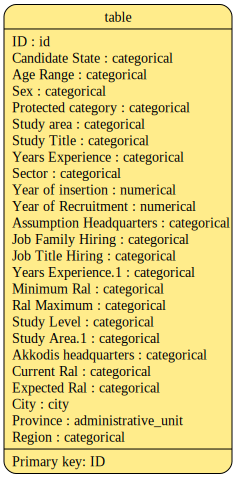

In [157]:
print('Auto detected data:\n')
metadata.visualize()

Creating a subsample of the data for training the model (12k IDs will kill your kernel, Colab tested at 1000 sequences/IDs)

In [158]:
# subsampled_data = get_random_sequence_subset(
#     data, 
#     metadata,
#     num_sequences=400
# )

## 2.3 Validation
Now, the metadata should be accurate. Let's validate that the metadata format makes sense. If successful, the code below should run without any errors.

In [159]:
metadata.validate()

# 3. Creating Synthetic Data
With these preparatory steps completed, we can now use the metadata description and data in the SDV. The coe below will train a model and create synthetic data.

In [160]:
# synthesizer = CTGANSynthesizer(
#     metadata,
#     locales='it_IT'
# )

In [ ]:

synthesizer = GaussianCopulaSynthesizer(
    metadata,
    locales='it_IT',
    verbose=True
)


/opt/anaconda3/envs/industryproject/lib/python3.11/site-packages/sdv/single_table/base.py:104: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



In [162]:
# synthesizer = CopulaGANSynthesizer(
#     metadata,
#     locales='it_IT',
#     verbose=True
# )

In [163]:
synthesizer.auto_assign_transformers(candidates)

In [164]:
synthesizer.get_transformers()


{'ID': RegexGenerator(regex_format='[1-9]{1,9}', enforce_uniqueness=True, generation_order='scrambled'),
 'Candidate State': UniformEncoder(),
 'Age Range': UniformEncoder(),
 'Sex': UniformEncoder(),
 'Protected category': UniformEncoder(),
 'Study area': UniformEncoder(),
 'Study Title': UniformEncoder(),
 'Years Experience': UniformEncoder(),
 'Sector': UniformEncoder(),
 'Year of insertion': FloatFormatter(computer_representation='Int64'),
 'Year of Recruitment': FloatFormatter(computer_representation='Int64'),
 'Assumption Headquarters': UniformEncoder(),
 'Job Family Hiring': UniformEncoder(),
 'Job Title Hiring': UniformEncoder(),
 'Years Experience.1': UniformEncoder(),
 'Minimum Ral': UniformEncoder(),
 'Ral Maximum': UniformEncoder(),
 'Study Level': UniformEncoder(),
 'Study Area.1': UniformEncoder(),
 'Akkodis headquarters': UniformEncoder(),
 'Current Ral': UniformEncoder(),
 'Expected Ral': UniformEncoder(),
 'City': AnonymizedFaker(provider_name='address.it_IT', function

In [165]:
print("Unique values in column A:", candidates['Year of Recruitment'].unique())
print(len(candidates['Study Level'].unique()))
percentages = candidates['Year of insertion'].value_counts(normalize=True) * 100
print(percentages)


Unique values in column A: <IntegerArray>
[<NA>, 2023, 2022, 2018, 2019, 2021, 2020, 2024]
Length: 8, dtype: Int64
8
Year of insertion
2022    43.762263
2021    36.290059
2023    14.829954
2019     1.970242
2018     1.659581
2020     1.487901
Name: proportion, dtype: Float64


In [166]:
synthesizer.update_transformers(column_name_to_transformer={
    'Study Title': OrderedUniformEncoder(order=['Middle school diploma', 'High school graduation', 'Three-year degree', 'Professional qualification',
                         'Five-year degree', "master's degree", 'Doctorate']),
    'Study Level': OrderedUniformEncoder(order=[None, 'Middle school diploma', 'High school graduation', 'Three-year degree', 'Professional qualification',
                         'Five-year degree', "master's degree", 'Doctorate']),
    'Age Range': OrderedUniformEncoder(order=['< 20 years', '20 - 25 years', '26 - 30 years', '31 - 35 years',
                                     '36 - 40 years', '40 - 45 years', '> 45 years' ]),
    'Minimum Ral': OrderedUniformEncoder(order=[None, '- 20K', '20-22K', '22-24K', '24-26K', '26-28K', '28-30K', '30-32K', '32-34K', '34-36K', '36-38K', '38-40K', '40-42K', '+50K']),
    'Ral Maximum': OrderedUniformEncoder(order=[None, '- 20K', '20-22K', '22-24K', '24-26K', '26-28K', '28-30K', '30-32K', '32-34K', '34-36K', '36-38K', '38-40K', '40-42K', '42-44K', '44-46K', '48-50K', '+50K']),
    'Current Ral': OrderedUniformEncoder(order=[None, '- 20 K', '20-22 K', '22-24 K', '24-26 K', '26-28 K', '28-30 K', '30-32 K', '32-34 K', '34-36 K', '36-38 K', '38-40 K', '40-42 K', '42-44 K', '44-46 K', '46-48 K', '48-50 K', '+ 50 K']),
    'Expected Ral': OrderedUniformEncoder(order=[None, '- 20 K', '20-22 K', '22-24 K', '24-26 K', '26-28 K', '28-30 K', '30-32 K', '32-34 K', '34-36 K', '36-38 K', '38-40 K', '40-42 K', '42-44 K', '44-46 K', '46-48 K', '48-50 K', '+ 50 K']),
    'Years Experience.1' : OrderedUniformEncoder(order=[None, '[0]', '[0-1]', '[1-3]', '[3-5]', '[5-7]', '[7-10]', '[+10]']),
    'Years Experience' : OrderedUniformEncoder(order=[ '[0]', '[0-1]', '[1-3]', '[3-5]', '[5-7]', '[7-10]', '[+10]']),
    'Year of insertion' : GaussianNormalizer(learn_rounding_scheme=True, distribution='gaussian_kde'),
    'Year of Recruitment' : GaussianNormalizer(learn_rounding_scheme=True, distribution='gaussian_kde')      
 
       
    })


In [167]:
synthesizer.get_transformers()

{'ID': RegexGenerator(regex_format='[1-9]{1,9}', enforce_uniqueness=True, generation_order='scrambled'),
 'Candidate State': UniformEncoder(),
 'Age Range': OrderedUniformEncoder(order=<CUSTOM>),
 'Sex': UniformEncoder(),
 'Protected category': UniformEncoder(),
 'Study area': UniformEncoder(),
 'Study Title': OrderedUniformEncoder(order=<CUSTOM>),
 'Years Experience': OrderedUniformEncoder(order=<CUSTOM>),
 'Sector': UniformEncoder(),
 'Year of insertion': GaussianNormalizer(learn_rounding_scheme=True),
 'Year of Recruitment': GaussianNormalizer(learn_rounding_scheme=True),
 'Assumption Headquarters': UniformEncoder(),
 'Job Family Hiring': UniformEncoder(),
 'Job Title Hiring': UniformEncoder(),
 'Years Experience.1': OrderedUniformEncoder(order=<CUSTOM>),
 'Minimum Ral': OrderedUniformEncoder(order=<CUSTOM>),
 'Ral Maximum': OrderedUniformEncoder(order=<CUSTOM>),
 'Study Level': OrderedUniformEncoder(order=<CUSTOM>),
 'Study Area.1': UniformEncoder(),
 'Akkodis headquarters': Unifor

### 3.1 Adding constraints

In [168]:
year_constraint = {
    'constraint_class': 'Inequality',
    'constraint_parameters': {
        'low_column_name': 'Year of insertion',
        'high_column_name': 'Year of Recruitment',
        'strict_boundaries': False
    }
}

# # location_constraint = {
# #     'constraint_class': 'FixedCombinations',
# #     'constraint_parameters': {
# #         'column_names': ['City', 'Province', 'Region']
# #     }
# # }

synthesizer.add_constraints(constraints=[
    year_constraint
])


### 3.2 Training the Synthesizer

In [169]:

# Step 2: Train the synthesizer
synthesizer.fit(candidates)


In [170]:

# Step 3: Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)

Sampling rows: 100%|██████████| 1000/1000 [00:06<00:00, 158.56it/s]


In [171]:
import os, datetime

mydir = os.path.join(os.getcwd(),'SDV/outputs/singletable/', datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(mydir)
print(mydir)

synthesizer.save(filepath=os.path.join(mydir, 'synthesizer.pkl'))

metadata = synthesizer.get_metadata()
metadata.save_to_json(filepath=os.path.join(mydir,'metadata.json'))

synthetic_data.to_csv(os.path.join(mydir, 'synthetic_data.csv'), index=False)

parameters = synthesizer.get_parameters()
with open(os.path.join(mydir, 'parameters.txt'), 'w') as f:
    f.write(str(parameters))


/Users/jarnostijnman/Documents/VS Code/AI Industry project/SDV/outputs/singletable/2024-12-09_21-23-19


## Diagnostics

In [172]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

# 1. perform basic validity checks
diagnostic = run_diagnostic(candidates, synthetic_data, metadata)

# 2. measure the statistical similarity
quality_report = evaluate_quality(candidates, synthetic_data, metadata)


# 3. plot the data
fig = get_column_plot(
    real_data=candidates,
    synthetic_data=synthetic_data,
    metadata=metadata,
    column_name='Year of insertion'
)
    
fig.show()

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 25/25 [00:00<00:00, 621.75it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 347.70it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 25/25 [00:00<00:00, 636.80it/s]|
Column Shapes Score: 87.2%

(2/2) Evaluating Column Pair Trends: |██████████| 300/300 [00:01<00:00, 167.79it/s]|
Column Pair Trends Score: 92.6%

Overall Score (Average): 89.9%



In [177]:


fig = quality_report.get_visualization(property_name='Column Pair Trends')
fig.show()
fig.write_html(os.path.join(mydir, 'column_pair_trends.html'))

# quality_report.get_details(property_name='Column Shapes')
quality_report.get_details(property_name='Column Pair Trends')


,Column 1,Column 2,Metric,Score,Real Correlation,Synthetic Correlation
0,Candidate State,Age Range,ContingencySimilarity,0.784170,NaN,NaN
1,Candidate State,Sex,ContingencySimilarity,0.960738,NaN,NaN
2,Candidate State,Protected category,ContingencySimilarity,0.959366,NaN,NaN
3,Candidate State,Study area,ContingencySimilarity,0.789141,NaN,NaN
4,Candidate State,Study Title,ContingencySimilarity,0.850466,NaN,NaN
...,...,...,...,...,...,...
226,Akkodis headquarters,Expected Ral,ContingencySimilarity,0.972819,NaN,NaN
227,Akkodis headquarters,Region,ContingencySimilarity,0.944619,NaN,NaN
228,Current Ral,Expected Ral,ContingencySimilarity,0.903425,NaN,NaN
229,Current Ral,Region,ContingencySimilarity,0.913190,NaN,NaN


# 4. Biased Sampling

,Sex
0,Male
1,Male
2,Male
3,Male
4,Male
...,...
95,Female
96,Female
97,Female
98,Female
